# Model

Import all needed in this notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoImageProcessor, ResNetForImageClassification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

## Model Creation

Create custom model based on microsoft ResNet 50

In [2]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
base_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")


class CustomResNetModel(nn.Module):
    def __init__(self, base_model, num_classes=3):
        super(CustomResNetModel, self).__init__()
        
        for name, param in base_model.named_parameters():
            if "encoder.stages.3" in name or "classifier" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        self.resnet = base_model 
        self.dropout1 = nn.Dropout(p=0.5)
        self.dense1 = nn.Linear(1000, 512) 
        self.dense2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dense3 = nn.Linear(256, 128)
        self.output = nn.Linear(128, num_classes) 

    def forward(self, x):
        x = self.resnet(x).logits 
        x = self.dropout1(x)
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = self.dropout2(x)
        x = torch.relu(self.dense3(x))
        x = self.output(x) 
        return x

num_classes = 2
custom_model = CustomResNetModel(base_model, num_classes=num_classes)


Print the structure of the model

In [3]:
print(custom_model)

CustomResNetModel(
  (resnet): ResNetForImageClassification(
    (resnet): ResNetModel(
      (embedder): ResNetEmbeddings(
        (embedder): ResNetConvLayer(
          (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
        )
        (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (encoder): ResNetEncoder(
        (stages): ModuleList(
          (0): ResNetStage(
            (layers): Sequential(
              (0): ResNetBottleNeckLayer(
                (shortcut): ResNetShortCut(
                  (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
                (layer): Sequential(
           

Print frozen and trainable parameters of model

In [4]:
for name, param in custom_model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

resnet.resnet.embedder.embedder.convolution.weight: Frozen
resnet.resnet.embedder.embedder.normalization.weight: Frozen
resnet.resnet.embedder.embedder.normalization.bias: Frozen
resnet.resnet.encoder.stages.0.layers.0.shortcut.convolution.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.shortcut.normalization.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.shortcut.normalization.bias: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.0.convolution.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.0.normalization.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.0.normalization.bias: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.1.convolution.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.1.normalization.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.1.normalization.bias: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.2.convolution.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.2.normalization.

## Dataset Retrieval

Retrieve dataset and compute X (data images in tensor format) and y (binary encoded label)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root="../nih_dataset/small_data/train", transform=transform)
test_dataset = datasets.ImageFolder(root="../nih_dataset/small_data/test", transform=transform)

In [6]:
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'normal': 0, 'pneumonia': 1}
{'normal': 0, 'pneumonia': 1}


In [7]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 80
Test dataset size: 40


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

for batch in train_loader:
    X_batch, y_batch = batch
    print(f"Batch X shape: {X_batch.shape}, batch y shape: {y_batch.shape}")
    break 

Batch X shape: torch.Size([32, 3, 224, 224]), batch y shape: torch.Size([32])


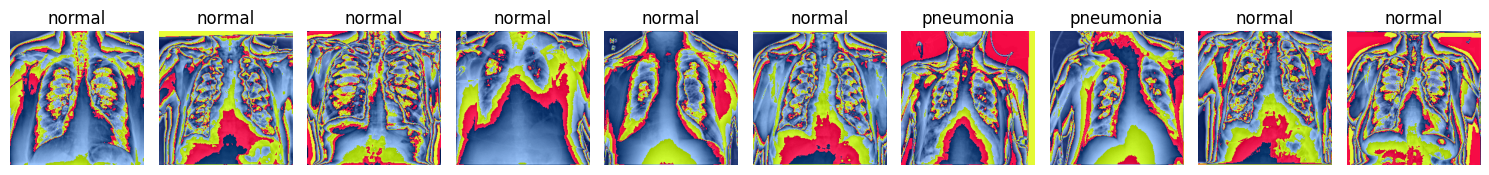

In [9]:
def display_images(images, labels, class_names):
    plt.figure(figsize=(15, 5))

    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1) 
        img = transforms.functional.to_pil_image(images[i])  
        plt.imshow(img)
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for batch in train_loader:
    X_batch, y_batch = batch
    class_names = train_dataset.classes
    display_images(X_batch[:10], y_batch[:10].tolist(), class_names)
    break

## Model Training And Evaluation

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    print(f"Device using for training: {device}")
    model = model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, unit="batch", desc=f"Epoch [{epoch+1}/{num_epochs}]") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies


def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = sum(test_losses) / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=1e-5)

num_epochs = 40
train_losses, train_accuracies, test_losses, test_accuracies = train_model(custom_model, train_loader, test_loader, criterion, optimizer, num_epochs)

Device using for training: cuda


Epoch [1/40]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/batch]


Epoch [1/40], Train Loss: 0.8564, Train Accuracy: 47.50%, Test Loss: 0.6869, Test Accuracy: 50.00%


Epoch [2/40]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18batch/s]


Epoch [2/40], Train Loss: 0.6973, Train Accuracy: 50.00%, Test Loss: 0.7014, Test Accuracy: 55.00%


Epoch [3/40]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19batch/s]


Epoch [3/40], Train Loss: 0.6906, Train Accuracy: 58.75%, Test Loss: 0.6905, Test Accuracy: 62.50%


Epoch [4/40]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16batch/s]


Epoch [4/40], Train Loss: 0.6894, Train Accuracy: 55.00%, Test Loss: 0.6772, Test Accuracy: 50.00%


Epoch [5/40]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15batch/s]


Epoch [5/40], Train Loss: 0.6966, Train Accuracy: 50.00%, Test Loss: 0.6984, Test Accuracy: 50.00%


Epoch [6/40]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15batch/s]


Epoch [6/40], Train Loss: 0.6929, Train Accuracy: 51.25%, Test Loss: 0.6902, Test Accuracy: 50.00%


Epoch [7/40]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16batch/s]


Epoch [7/40], Train Loss: 0.6875, Train Accuracy: 53.75%, Test Loss: 0.6849, Test Accuracy: 65.00%


Epoch [8/40]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16batch/s]


Epoch [8/40], Train Loss: 0.6822, Train Accuracy: 67.50%, Test Loss: 0.6921, Test Accuracy: 57.50%


Epoch [9/40]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15batch/s]


Epoch [9/40], Train Loss: 0.6872, Train Accuracy: 55.00%, Test Loss: 0.6935, Test Accuracy: 50.00%


Epoch [10/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16batch/s]


Epoch [10/40], Train Loss: 0.6797, Train Accuracy: 52.50%, Test Loss: 0.6915, Test Accuracy: 52.50%


Epoch [11/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16batch/s]


Epoch [11/40], Train Loss: 0.6794, Train Accuracy: 55.00%, Test Loss: 0.6793, Test Accuracy: 55.00%


Epoch [12/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16batch/s]


Epoch [12/40], Train Loss: 0.6805, Train Accuracy: 58.75%, Test Loss: 0.6907, Test Accuracy: 57.50%


Epoch [13/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16batch/s]


Epoch [13/40], Train Loss: 0.6749, Train Accuracy: 70.00%, Test Loss: 0.6789, Test Accuracy: 57.50%


Epoch [14/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18batch/s]


Epoch [14/40], Train Loss: 0.6756, Train Accuracy: 76.25%, Test Loss: 0.6797, Test Accuracy: 65.00%


Epoch [15/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14batch/s]


Epoch [15/40], Train Loss: 0.6705, Train Accuracy: 71.25%, Test Loss: 0.6791, Test Accuracy: 62.50%


Epoch [16/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14batch/s]


Epoch [16/40], Train Loss: 0.6667, Train Accuracy: 61.25%, Test Loss: 0.6827, Test Accuracy: 57.50%


Epoch [17/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14batch/s]


Epoch [17/40], Train Loss: 0.6699, Train Accuracy: 57.50%, Test Loss: 0.6659, Test Accuracy: 52.50%


Epoch [18/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14batch/s]


Epoch [18/40], Train Loss: 0.6687, Train Accuracy: 57.50%, Test Loss: 0.6675, Test Accuracy: 52.50%


Epoch [19/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14batch/s]


Epoch [19/40], Train Loss: 0.6621, Train Accuracy: 63.75%, Test Loss: 0.6793, Test Accuracy: 65.00%


Epoch [20/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11batch/s]


Epoch [20/40], Train Loss: 0.6610, Train Accuracy: 73.75%, Test Loss: 0.6763, Test Accuracy: 70.00%


Epoch [21/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16batch/s]


Epoch [21/40], Train Loss: 0.6623, Train Accuracy: 77.50%, Test Loss: 0.6745, Test Accuracy: 70.00%


Epoch [22/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15batch/s]


Epoch [22/40], Train Loss: 0.6575, Train Accuracy: 85.00%, Test Loss: 0.6731, Test Accuracy: 57.50%


Epoch [23/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13batch/s]


Epoch [23/40], Train Loss: 0.6528, Train Accuracy: 86.25%, Test Loss: 0.6694, Test Accuracy: 60.00%


Epoch [24/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15batch/s]


Epoch [24/40], Train Loss: 0.6524, Train Accuracy: 85.00%, Test Loss: 0.6677, Test Accuracy: 65.00%


Epoch [25/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16batch/s]


Epoch [25/40], Train Loss: 0.6460, Train Accuracy: 85.00%, Test Loss: 0.6684, Test Accuracy: 60.00%


Epoch [26/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12batch/s]


Epoch [26/40], Train Loss: 0.6447, Train Accuracy: 86.25%, Test Loss: 0.6741, Test Accuracy: 60.00%


Epoch [27/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14batch/s]


Epoch [27/40], Train Loss: 0.6481, Train Accuracy: 86.25%, Test Loss: 0.6741, Test Accuracy: 62.50%


Epoch [28/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16batch/s]


Epoch [28/40], Train Loss: 0.6406, Train Accuracy: 87.50%, Test Loss: 0.6746, Test Accuracy: 60.00%


Epoch [29/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12batch/s]


Epoch [29/40], Train Loss: 0.6388, Train Accuracy: 90.00%, Test Loss: 0.6643, Test Accuracy: 62.50%


Epoch [30/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13batch/s]


Epoch [30/40], Train Loss: 0.6354, Train Accuracy: 92.50%, Test Loss: 0.6730, Test Accuracy: 62.50%


Epoch [31/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12batch/s]


Epoch [31/40], Train Loss: 0.6352, Train Accuracy: 88.75%, Test Loss: 0.6483, Test Accuracy: 65.00%


Epoch [32/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11batch/s]


Epoch [32/40], Train Loss: 0.6318, Train Accuracy: 86.25%, Test Loss: 0.6660, Test Accuracy: 65.00%


Epoch [33/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14batch/s]


Epoch [33/40], Train Loss: 0.6242, Train Accuracy: 87.50%, Test Loss: 0.6692, Test Accuracy: 60.00%


Epoch [34/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13batch/s]


Epoch [34/40], Train Loss: 0.6221, Train Accuracy: 86.25%, Test Loss: 0.6643, Test Accuracy: 65.00%


Epoch [35/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12batch/s]


Epoch [35/40], Train Loss: 0.6145, Train Accuracy: 91.25%, Test Loss: 0.6628, Test Accuracy: 62.50%


Epoch [36/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch [36/40], Train Loss: 0.6150, Train Accuracy: 93.75%, Test Loss: 0.6773, Test Accuracy: 67.50%


Epoch [37/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch [37/40], Train Loss: 0.6064, Train Accuracy: 91.25%, Test Loss: 0.6558, Test Accuracy: 70.00%


Epoch [38/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10batch/s]


Epoch [38/40], Train Loss: 0.6039, Train Accuracy: 93.75%, Test Loss: 0.6622, Test Accuracy: 67.50%


Epoch [39/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10batch/s]


Epoch [39/40], Train Loss: 0.6018, Train Accuracy: 93.75%, Test Loss: 0.6522, Test Accuracy: 67.50%


Epoch [40/40]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13batch/s]


Epoch [40/40], Train Loss: 0.5929, Train Accuracy: 95.00%, Test Loss: 0.6607, Test Accuracy: 62.50%


## Model Evaluation

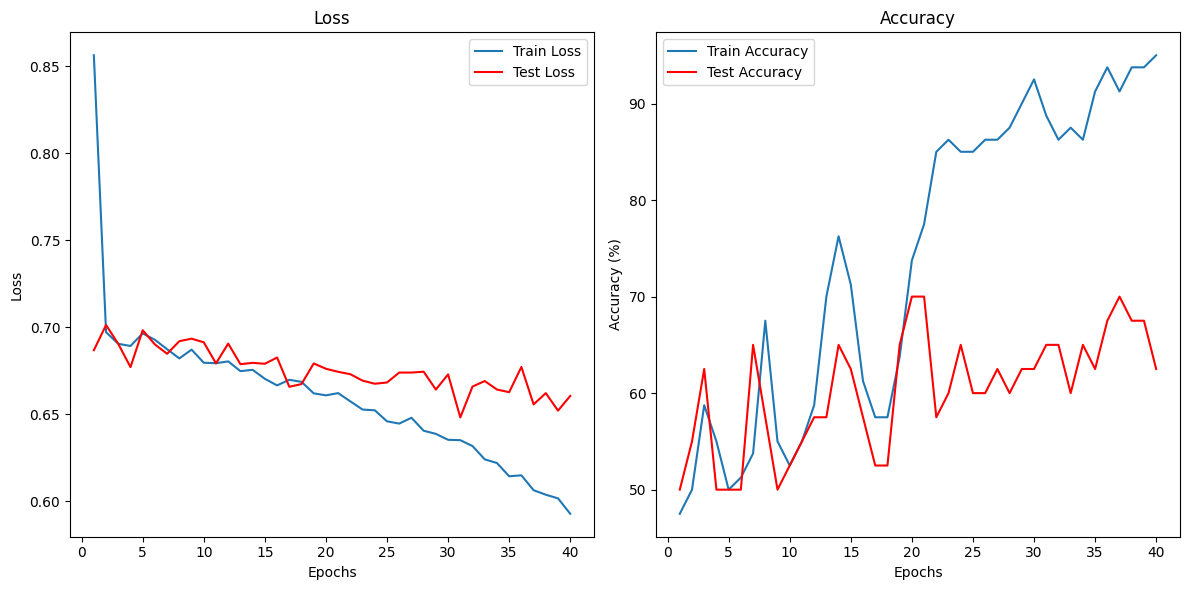

In [13]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss", color="r")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy", color="r")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

## Model Saving

In [14]:
torch.save(custom_model.state_dict(), "../models/modelv1.1.pth")